# Student Pathways Earnings Analysis

Exploratory analysis and modeling for the CS x62 Data Challenge 1 dataset. The notebook explores data quality, demographic wage patterns, and trains a regression model to predict fourth-year wages (`WAGE_YEAR4`).

In [47]:
from pathlib import Path
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='deep')
pd.set_option('display.max_columns', None)
DATA_DIR = Path('.')
train_path = DATA_DIR / 'earnings_train.csv'
test_path = DATA_DIR / 'earnings_test_features.csv'

df = pd.read_csv(train_path)
test_features = pd.read_csv(test_path)

print(f"Training rows: {df.shape[0]:,}, columns: {df.shape[1]}")
df.head()


Training rows: 20,705, columns: 11


,DISTRICT_TYPE,DISTRICT_NAME,DISTRICT_CODE,ACADEMIC_YEAR,DEMO_CATEGORY,STUDENT_POPULATION,AWARD_CATEGORY,WAGE_YEAR1,WAGE_YEAR2,WAGE_YEAR3,WAGE_YEAR4
0,School District,Duarte Unified,1964469.0,2018-2019,Race,None Reported,Bachelor's Degree - Did Not Transfer,0.0,0.0,0.0,0.0
1,School District,Coronado Unified,3768031.0,2018-2019,Race,None Reported,Associate Degree,0.0,0.0,0.0,0.0
2,School District,Gilroy Unified,4369484.0,2018-2019,Race,Black or African American,Bachelor's Degree - Did Not Transfer,0.0,0.0,0.0,0.0
3,School District,Pleasant Valley,5672553.0,2018-2019,Homeless Status,Did Not Experience Homelessness in K-12,Community College Certificate,0.0,0.0,0.0,0.0
4,Legislative District,Senate District 15,NaN,2018-2019,Race,American Indian or Alaska Native,Community College Certificate,0.0,0.0,0.0,0.0


## Data quality (EDA)

In [48]:
data_quality = pd.DataFrame({
    'dtype': df.dtypes,
    'missing': df.isna().sum(),
    'missing_pct': (df.isna().mean() * 100).round(2),
    'cardinality': df.nunique()
}).sort_index()

data_quality

,dtype,missing,missing_pct,cardinality
ACADEMIC_YEAR,object,0,0.00,1
AWARD_CATEGORY,object,0,0.00,4
DEMO_CATEGORY,object,0,0.00,5
DISTRICT_CODE,float64,2745,13.26,571
DISTRICT_NAME,object,0,0.00,692
DISTRICT_TYPE,object,0,0.00,3
STUDENT_POPULATION,object,0,0.00,15
WAGE_YEAR1,float64,0,0.00,2278
WAGE_YEAR2,float64,0,0.00,2295
WAGE_YEAR3,float64,0,0.00,2286


### Unique categorical values

In [49]:
categorical_cols = df.select_dtypes(include='object').columns
cat_summary = pd.DataFrame({
    'unique_count': [df[c].nunique() for c in categorical_cols],
    'examples': [', '.join(sorted(df[c].unique())[:8]) + (' …' if df[c].nunique() > 8 else '') for c in categorical_cols]
}, index=categorical_cols)
cat_summary

,unique_count,examples
DISTRICT_TYPE,3,"All, Legislative District, School District"
DISTRICT_NAME,692,"ABC Unified, Acalanes Union High, Acton-Agua D..."
ACADEMIC_YEAR,1,2018-2019
DEMO_CATEGORY,5,"All, Foster Status, Gender, Homeless Status, Race"
STUDENT_POPULATION,15,"All, American Indian or Alaska Native, Asian, ..."
AWARD_CATEGORY,4,"Associate Degree, Bachelor's Degree - Did Not ..."


### Numeric ranges and distribution

In [50]:
numeric_cols = df.select_dtypes(include='number').columns
numeric_summary = df[numeric_cols].agg(['min', 'max', 'mean', 'median', 'std', 'skew']).T
numeric_summary

,min,max,mean,median,std,skew
DISTRICT_CODE,110017.0,5872769.0,3.041331e+06,3166852.0,1.583286e+06,-0.017289
WAGE_YEAR1,0.0,97993.0,4.476107e+03,0.0,1.194450e+04,2.782885
WAGE_YEAR2,0.0,132847.0,6.075533e+03,0.0,1.614092e+04,2.699593
WAGE_YEAR3,0.0,146728.0,7.310832e+03,0.0,1.915820e+04,2.591562
WAGE_YEAR4,0.0,153910.0,8.530890e+03,0.0,2.210666e+04,2.498483


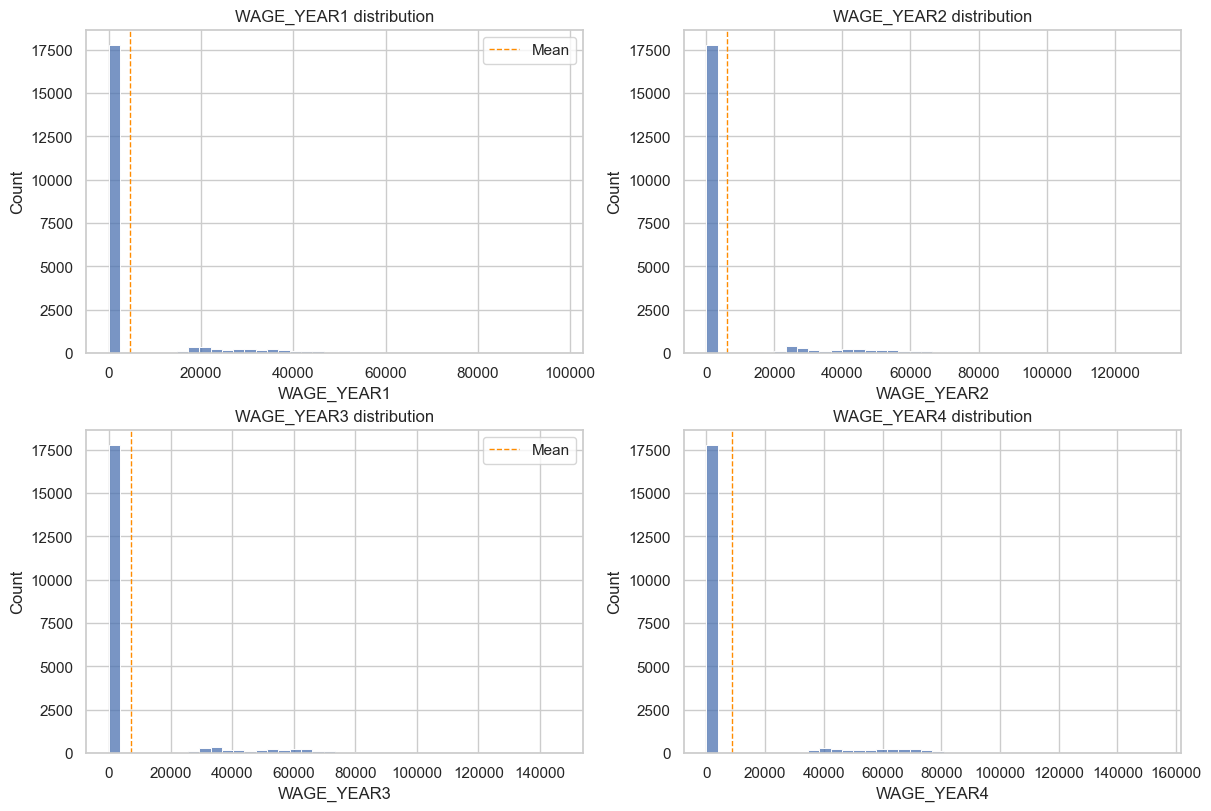

In [51]:
wage_cols = ['WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3', 'WAGE_YEAR4']
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
for col, ax in zip(wage_cols, axes.flatten()):
    sns.histplot(df[col], bins=40, ax=ax, edgecolor='white')
    ax.axvline(df[col].mean(), color='darkorange', linestyle='--', linewidth=1, label='Mean')
    ax.set_title(f"{col} distribution")
    if col in ['WAGE_YEAR1', 'WAGE_YEAR3']:
        ax.legend()
plt.show()


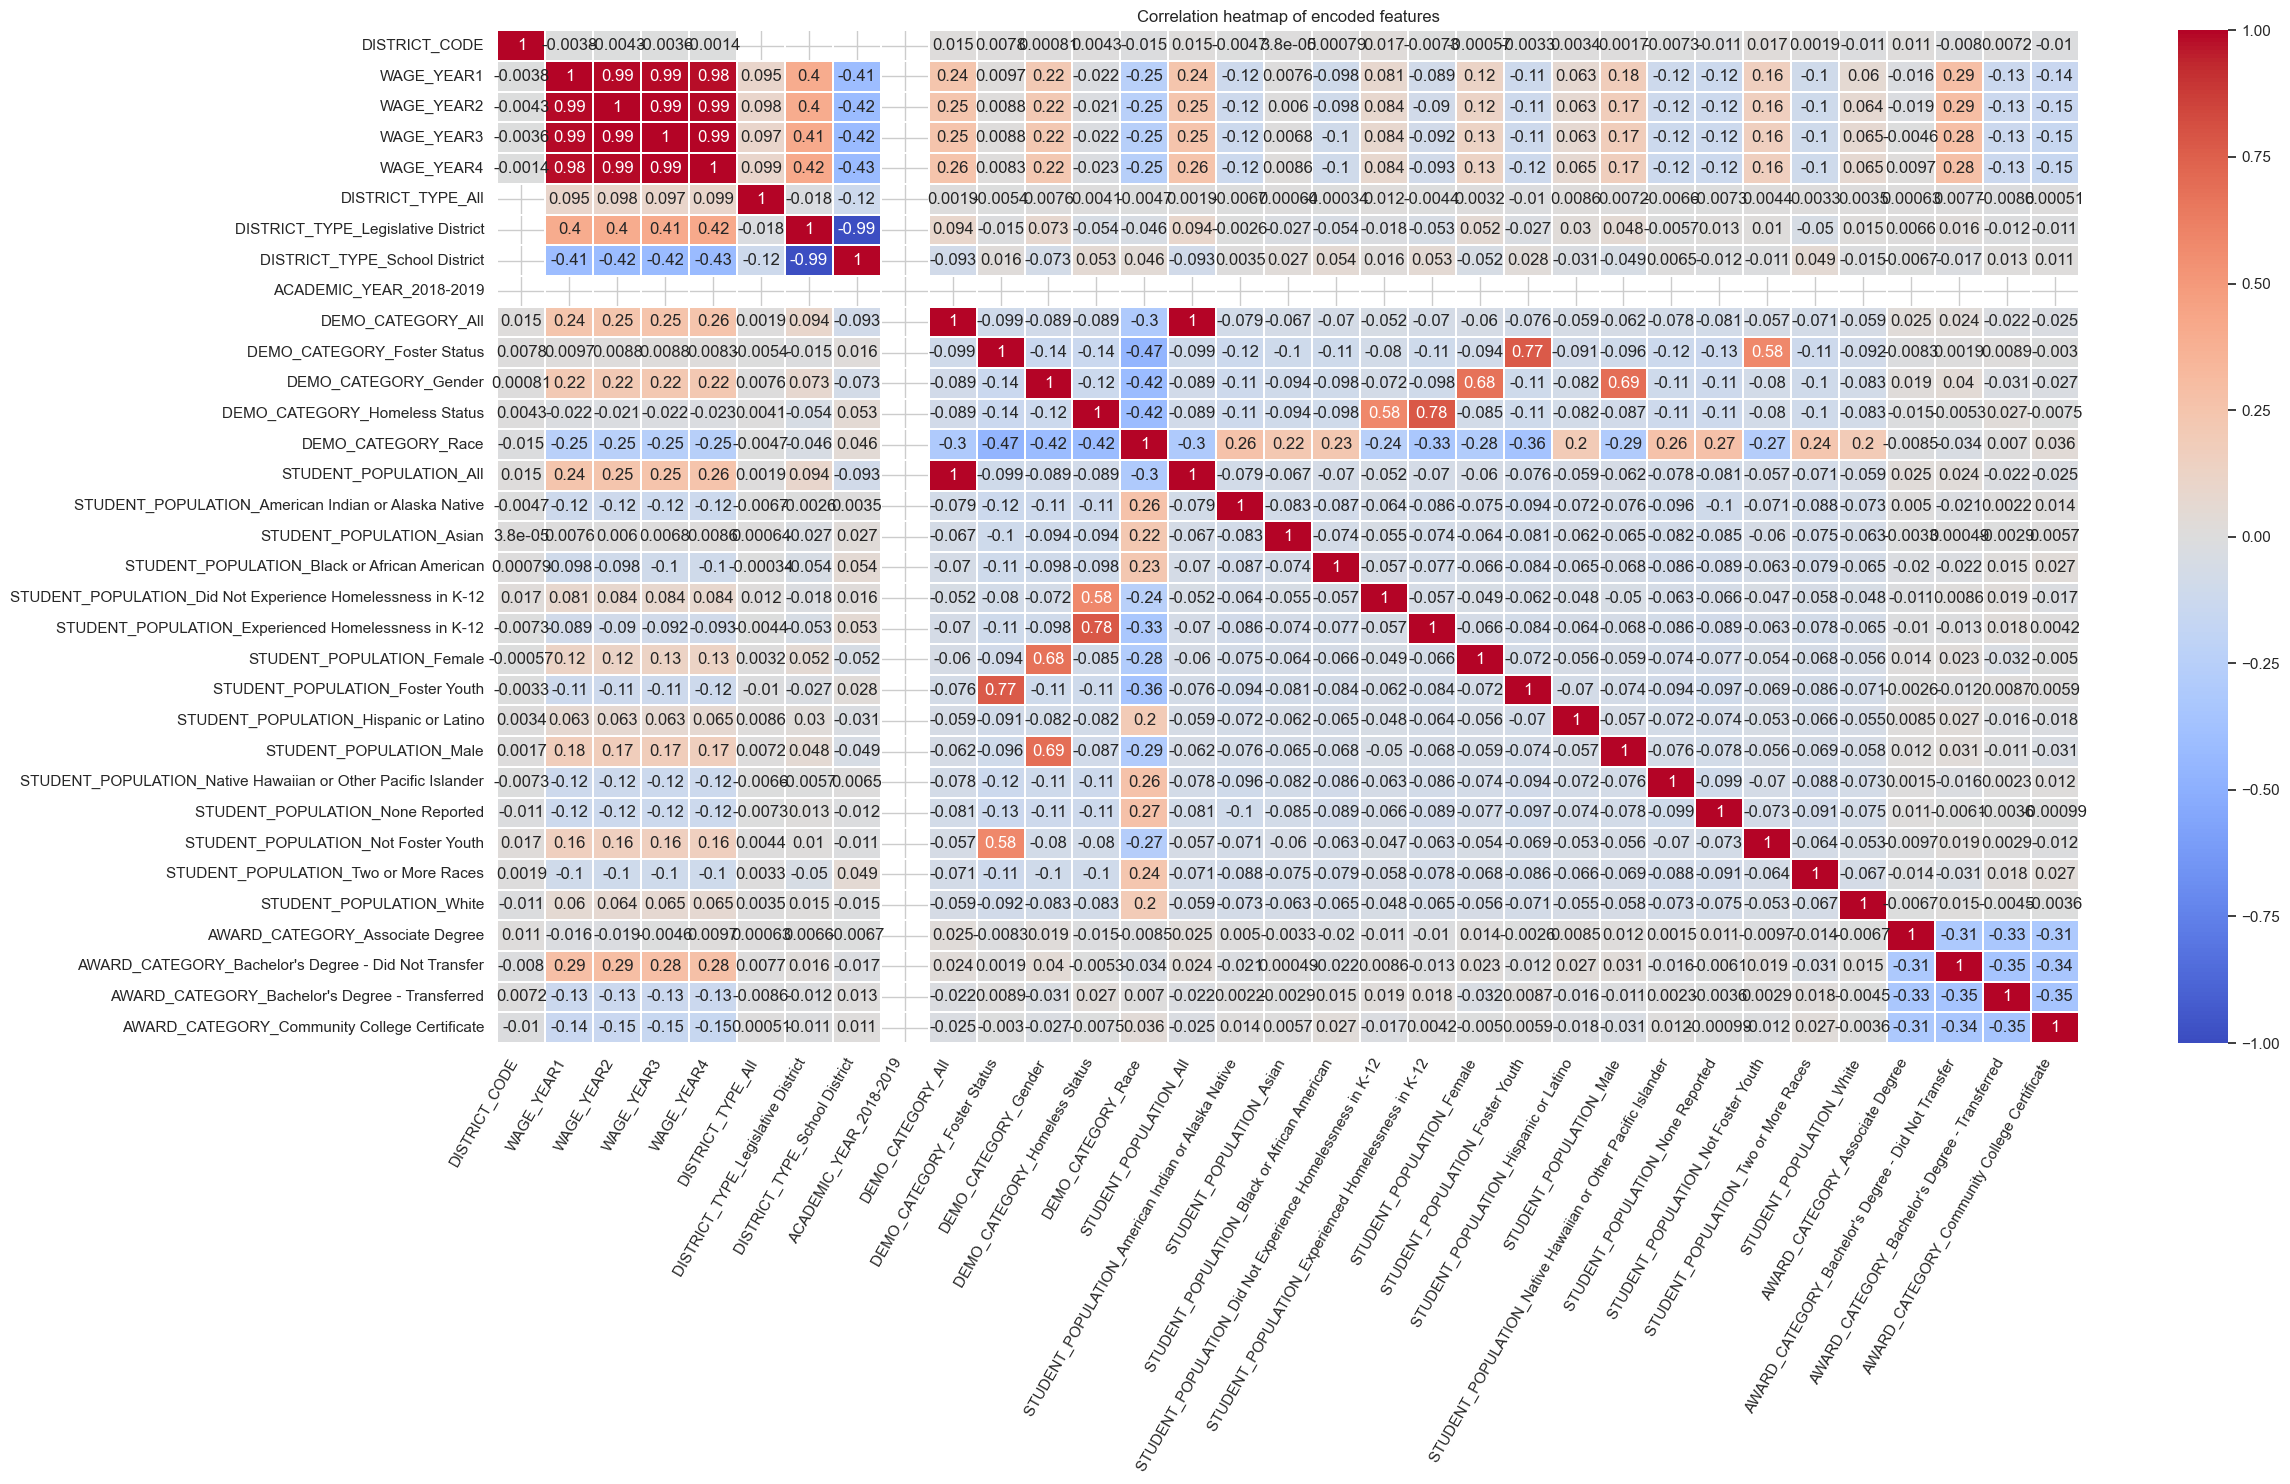

In [73]:
from pathlib import Path

heatmap_frame = df.drop(columns=['DISTRICT_NAME']).copy()

heatmap_numeric = ['DISTRICT_CODE','WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3', 'WAGE_YEAR4']
heatmap_categorical = [c for c in heatmap_frame.columns if c not in heatmap_numeric]

heatmap_encoded = heatmap_frame.copy()
heatmap_encoded = pd.get_dummies(heatmap_encoded, columns=heatmap_categorical, drop_first=False)

heatmap_corr = heatmap_encoded.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(heatmap_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.3, annot=True)
plt.title('Correlation heatmap of encoded features')
plt.xticks(rotation=60, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
Path('screenshot').mkdir(exist_ok=True)
plt.savefig('screenshot/encoded_feature_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


### Average year-4 wages by credential

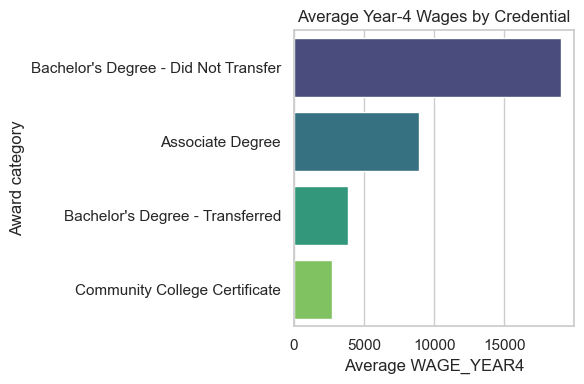

In [53]:
award_means = (df.groupby('AWARD_CATEGORY')['WAGE_YEAR4']
                .mean()
                .reset_index()
                .sort_values('WAGE_YEAR4', ascending=False))
plt.figure(figsize=(6, 4))
sns.barplot(data=award_means, x='WAGE_YEAR4', y='AWARD_CATEGORY', hue='AWARD_CATEGORY', palette='viridis', legend=False)
plt.xlabel('Average WAGE_YEAR4')
plt.ylabel('Award category')
plt.title('Average Year-4 Wages by Credential')
plt.tight_layout()
plt.show()

### Additional CS 562 exploration

In [54]:
student_group_stats = (
    df.groupby('STUDENT_POPULATION')['WAGE_YEAR3']
      .agg(['count', 'mean', 'median'])
      .sort_values('mean', ascending=False)
)
print('Highest mean WAGE_YEAR3 subgroups:')
display(student_group_stats.head(8))
print('Lowest mean WAGE_YEAR3 subgroups:')
display(student_group_stats.tail(8))


Highest mean WAGE_YEAR3 subgroups:


,count,mean,median
STUDENT_POPULATION,,,
All,1236,26430.241100,30997.0
Not Foster Youth,1015,20893.018719,0.0
Male,1171,20810.238258,0.0
Female,1120,17612.725000,0.0
Did Not Experience Homelessness in K-12,836,15183.008373,0.0
White,1089,12624.307622,0.0
Hispanic or Latino,1062,12535.306968,0.0
Asian,1372,7799.214286,0.0


Lowest mean WAGE_YEAR3 subgroups:


,count,mean,median
STUDENT_POPULATION,,,
Asian,1372,7799.214286,0.0
Experienced Homelessness in K-12,1472,944.094429,0.0
Black or African American,1484,446.686658,0.0
Two or More Races,1539,336.699805,0.0
Foster Youth,1739,61.852789,0.0
Native Hawaiian or Other Pacific Islander,1810,53.338674,0.0
American Indian or Alaska Native,1833,49.171304,0.0
None Reported,1927,42.887909,0.0


In [55]:
demo_stats = (
    df.groupby(['DEMO_CATEGORY', 'STUDENT_POPULATION'])['WAGE_YEAR3']
      .mean()
      .sort_values(ascending=False)
)
demo_stats.head(10)


DEMO_CATEGORY    STUDENT_POPULATION                     
All              All                                        26430.241100
Foster Status    Not Foster Youth                           20893.018719
Gender           Male                                       20810.238258
                 Female                                     17612.725000
Homeless Status  Did Not Experience Homelessness in K-12    15183.008373
Race             White                                      12624.307622
                 Hispanic or Latino                         12535.306968
                 Asian                                       7799.214286
Homeless Status  Experienced Homelessness in K-12             944.094429
Race             Black or African American                    446.686658
Name: WAGE_YEAR3, dtype: float64

In [56]:
trend_series = df['WAGE_YEAR4'] - df['WAGE_YEAR1']
print(f"Positive wage trends: {(trend_series > 0).sum():,}")
print(f"Negative wage trends: {(trend_series < 0).sum():,}")

positive = df.loc[trend_series > 0].copy()
positive['wage_trend'] = trend_series[trend_series > 0]
positive_summary = (
    positive.groupby(['DEMO_CATEGORY', 'STUDENT_POPULATION'])['wage_trend']
            .agg(['count', 'mean'])
            .sort_values('count', ascending=False)
)
positive_summary

Positive wage trends: 2,935
Negative wage trends: 0


count          mean
DEMO_CATEGORY   STUDENT_POPULATION                                            
All             All                                          672  27524.066964
Gender          Female                                       421  26900.040380
Foster Status   Not Foster Youth                             419  27618.565632
Gender          Male                                         411  31102.978102
Race            Hispanic or Latino                           293  25325.310580
                White                                        244  31525.922131
Homeless Status Did Not Experience Homelessness in K-12      236  29582.415254
Race            Asian                                        174  34898.201149
Homeless Status Experienced Homelessness in K-12              33  23324.090909
Race            Black or African American                     15  22585.866667
                Two or More Races                              9  28850.888889
Foster Status   Foster Youth                                   2  31601.000000
Race            American Indian or Alaska Native               2  26180.000000
                Native Hawaiian or Other Pacific Islander      2  32434.000000
                None Reported                                  2  31376.000000

The filtered summary above shows which demographics have the most records with positive wage trajectories. No subgroup exhibited a negative trend in this dataset because `WAGE_YEAR4 ≥ WAGE_YEAR1` for every record.

## Modeling WAGE_YEAR4

### Feature engineering
- Drop ID-like columns (`DISTRICT_NAME`, `DISTRICT_CODE`, `ACADEMIC_YEAR`).
- Build three growth features to capture the year-over-year wage momentum.


In [57]:
def prepare_model_features(frame: pd.DataFrame) -> pd.DataFrame:
    temp = frame.drop(columns=['DISTRICT_NAME', 'DISTRICT_CODE', 'ACADEMIC_YEAR']).copy()
    temp['WAGE_GROWTH_Y2_Y1'] = temp['WAGE_YEAR2'] - temp['WAGE_YEAR1']
    temp['WAGE_GROWTH_Y3_Y2'] = temp['WAGE_YEAR3'] - temp['WAGE_YEAR2']
    temp['WAGE_GROWTH_Y3_Y1'] = temp['WAGE_YEAR3'] - temp['WAGE_YEAR1']
    return temp

feature_df = prepare_model_features(df)

X = feature_df.drop(columns=['WAGE_YEAR4'])
y = feature_df['WAGE_YEAR4']

numeric_features = [
    'WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3',
    'WAGE_GROWTH_Y2_Y1', 'WAGE_GROWTH_Y3_Y2', 'WAGE_GROWTH_Y3_Y1'
]
categorical_features = [c for c in X.columns if c not in numeric_features]


### Modeling pipeline


In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Baseline benchmarking
- Compare the allowed algorithms (linear, tree, KNN) under the shared preprocessing pipeline.


In [59]:
candidate_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree (depth=12, leaf=25)': DecisionTreeRegressor(max_depth=12, min_samples_leaf=25, random_state=42),
    'KNN (k=7, distance-weighted)': KNeighborsRegressor(n_neighbors=7, weights='distance')
}


,model,MAE,RMSE,R^2
0,"KNN (k=7, distance-weighted)",420.865105,1836.470375,0.992994
1,"Decision Tree (depth=12, leaf=25)",620.369695,2293.722004,0.989070
2,Linear Regression,919.986273,2449.081921,0.987540


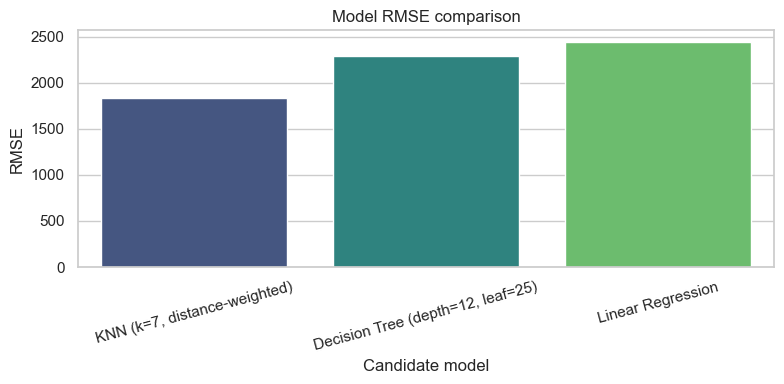

In [60]:
benchmark_rows = []
for name, estimator in candidate_models.items():
    model_pipe = Pipeline([
        ('preprocess', preprocess),
        ('model', estimator)
    ])
    model_pipe.fit(X_train, y_train)
    preds = model_pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)
    benchmark_rows.append({'model': name, 'MAE': mae, 'RMSE': rmse, 'R^2': r2})

benchmark_df = pd.DataFrame(benchmark_rows).sort_values('RMSE').reset_index(drop=True)
display(benchmark_df)

plt.figure(figsize=(8, 4))
sns.barplot(data=benchmark_df, x='model', y='RMSE', hue='model', palette='viridis', legend=False)
plt.ylabel('RMSE')
plt.xlabel('Candidate model')
plt.title('Model RMSE comparison')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### KNN hyperparameter sweep (Cross-validate)


,k,CV_MAE
0,3,495.562774
1,5,472.527148
2,7,458.393401
3,9,449.374313
4,11,445.830246
5,15,440.278844


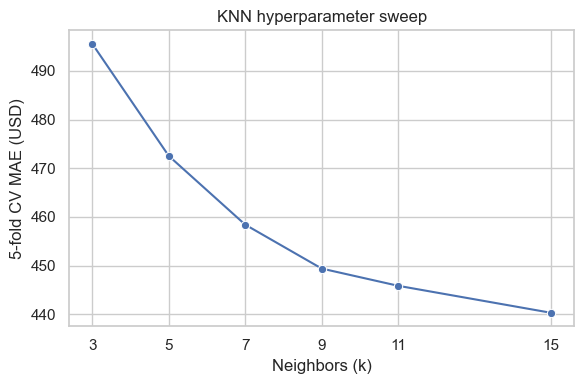

In [61]:
k_grid = [3, 5, 7, 9, 11, 15]
knn_tuning_rows = []
for k in k_grid:
    tuned_pipe = Pipeline([
        ('preprocess', preprocess),
        ('model', KNeighborsRegressor(n_neighbors=k, weights='distance'))
    ])
    scores = cross_val_score(tuned_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
    knn_tuning_rows.append({'k': k, 'CV_MAE': -scores.mean()})

tuning_df = pd.DataFrame(knn_tuning_rows)
display(tuning_df)

plt.figure(figsize=(6, 4))
sns.lineplot(data=tuning_df, x='k', y='CV_MAE', marker='o')
plt.xlabel('Neighbors (k)')
plt.ylabel('5-fold CV MAE (USD)')
plt.title('KNN hyperparameter sweep')
plt.xticks(k_grid)
plt.tight_layout()
plt.show()


### Final KNN model


In [62]:
best_k = int(tuning_df.loc[tuning_df['CV_MAE'].idxmin(), 'k'])
print(f"Best k from CV sweep: {best_k}")

best_model = KNeighborsRegressor(n_neighbors=best_k, weights='distance')

pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', best_model)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()

print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R^2: {r2:.3f}")
print(f"5-fold CV MAE: {cv_mae:,.0f} (folds: {', '.join(f'{-s:,.0f}' for s in cv_scores)})")

Best k from CV sweep: 15
MAE: 402
RMSE: 1,784
R^2: 0.993
5-fold CV MAE: 440 (folds: 464, 427, 471, 446, 394)


### Permutation importance


In [63]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
importance = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False)
importance


WAGE_YEAR3            6.025327e-01
WAGE_YEAR2            2.829426e-01
WAGE_YEAR1            8.842391e-02
WAGE_GROWTH_Y3_Y1     7.428125e-03
WAGE_GROWTH_Y3_Y2     4.295003e-03
WAGE_GROWTH_Y2_Y1     4.080941e-03
STUDENT_POPULATION    5.409879e-07
DEMO_CATEGORY         1.955409e-07
AWARD_CATEGORY        8.673638e-08
DISTRICT_TYPE         6.253342e-08
dtype: float64

### Test-set inference


In [64]:
inference_features = prepare_model_features(test_features)
test_predictions = pipe.predict(inference_features)
submission = pd.DataFrame({
    'WAGE_YEAR4': test_predictions
})
submission.to_csv('preds.csv', index=False)
submission.head()

,WAGE_YEAR4
0,0.000000
1,43556.185239
2,0.000000
3,0.000000
4,39708.852096


### Credential-level predictions
- Average actual vs. predicted wages by award to visualize the model narrative.


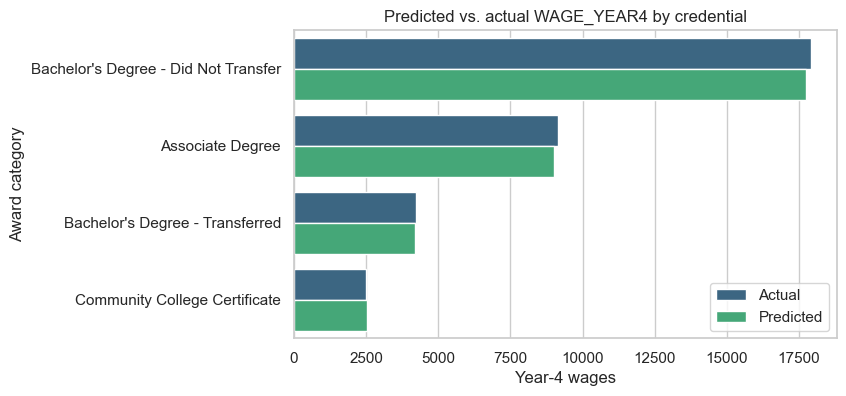

,AWARD_CATEGORY,Actual,Predicted
1,Bachelor's Degree - Did Not Transfer,17907.799632,17759.844111
0,Associate Degree,9133.292952,9020.860775
2,Bachelor's Degree - Transferred,4228.437333,4197.335241
3,Community College Certificate,2479.408824,2519.139918


In [65]:
test_slice = X_test.copy()
test_slice["Actual_WAGE_YEAR4"] = y_test
test_slice["Pred_WAGE_YEAR4"] = pipe.predict(X_test)

award_pred = (
    test_slice.groupby("AWARD_CATEGORY")[["Actual_WAGE_YEAR4", "Pred_WAGE_YEAR4"]]
              .mean()
              .rename(columns={"Actual_WAGE_YEAR4": "Actual", "Pred_WAGE_YEAR4": "Predicted"})
              .reset_index()
              .sort_values("Predicted", ascending=False)
)

award_long = award_pred.melt(id_vars="AWARD_CATEGORY", value_vars=["Actual", "Predicted"],
                              var_name="Series", value_name="WAGE_YEAR4")

plt.figure(figsize=(7, 4))
sns.barplot(data=award_long, x="WAGE_YEAR4", y="AWARD_CATEGORY", hue="Series", palette="viridis")
plt.xlabel("Year-4 wages")
plt.ylabel("Award category")
plt.title("Predicted vs. actual WAGE_YEAR4 by credential")
plt.legend(title="")
plt.show()

award_pred


### Model trend diagnostics


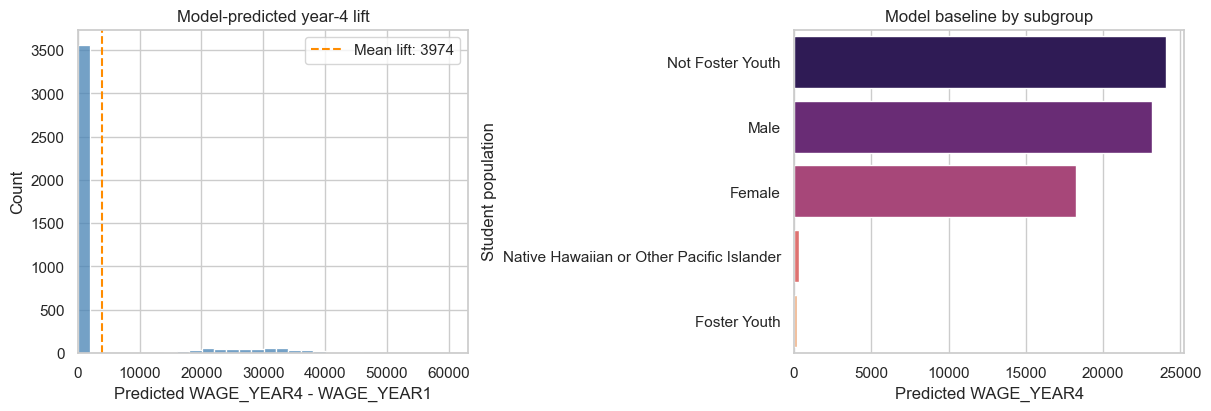

In [66]:
model_slice = X_test.copy()
model_slice["Pred_WAGE_YEAR4"] = pipe.predict(X_test)
model_slice["Pred_Lift"] = model_slice["Pred_WAGE_YEAR4"] - model_slice["WAGE_YEAR1"]
positive_share = (model_slice["Pred_Lift"] > 0).mean()

focus_groups = ['Not Foster Youth', 'Male', 'Female', 'Native Hawaiian or Other Pacific Islander', 'Foster Youth']
focus_df = (
    model_slice[model_slice["STUDENT_POPULATION"].isin(focus_groups)]
    .groupby("STUDENT_POPULATION")["Pred_WAGE_YEAR4"]
    .agg(count="size", mean="mean")
    .reset_index()
)
focus_df["STUDENT_POPULATION"] = pd.Categorical(focus_df["STUDENT_POPULATION"], categories=focus_groups, ordered=True)
focus_df = focus_df.sort_values("STUDENT_POPULATION")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
sns.histplot(model_slice["Pred_Lift"], bins=30, ax=axes[0], color="steelblue")
axes[0].axvline(model_slice["Pred_Lift"].mean(), color="darkorange", linestyle="--", label=f"Mean lift: {model_slice['Pred_Lift'].mean():.0f}")
axes[0].set_title("Model-predicted year-4 lift")
axes[0].set_xlabel("Predicted WAGE_YEAR4 - WAGE_YEAR1")
axes[0].set_ylabel("Count")
axes[0].set_xlim(left=max(0, model_slice["Pred_Lift"].min() * 0.95))
axes[0].legend()

sns.barplot(data=focus_df, x="mean", y="STUDENT_POPULATION", hue="STUDENT_POPULATION", ax=axes[1], palette="magma", dodge=False, legend=False)
axes[1].set_xlabel("Predicted WAGE_YEAR4")
axes[1].set_ylabel("Student population")
axes[1].set_title("Model baseline by subgroup")

plt.show()


## Part 3. Reflection
**Which features best predict the target outcome (WAGE_YEAR4)?**

![Permutation importance](screenshot/importance.png)

- Permutation importance says the prior wage levels do almost all the work: shuffling `WAGE_YEAR3` spikes MAE by ~0.60, `WAGE_YEAR2` by ~0.28, and `WAGE_YEAR1` by ~0.088, so the distance-weighted KNN basically hunts for districts that already looked alike in years 1–3.
- The growth features barely move the needle but help break ties `WAGE_GROWTH_Y3_Y1` costs ~0.007 MAE when permuted and the two shorter growth diffs sit near 0.004, which is just enough signal to separate districts with the same absolute wages but different acceleration.

**What does your model say about the people or populations whose data is provided?**
![Year-4 wages by credential](screenshot/predicted_award_bar.png)
- The fitted KNN model suggests that credentials are the dominant factor driving wage differences.
On the hold-out set, predicted year-4 wages align closely with actuals: bachelor’s cohorts who stayed put earn about 17.9K (actual 17.8K), associate’s near 9.1K (pred. 9.0K), bachelor’s-after-transfer around 4.2K, and certificate earners near 2.5K mirroring the order learned from the data.
![Model trend summary](screenshot/model_trends.png)
- The left histogram shows the model’s predicted lift for the hold-out split, and every bar sits to the right of zero, so the model is literally telling us “everyone keeps gaining,” with the Mean lift legend value reporting how big that gain is on average.
- The right panel zooms in on a few subgroups and the model keeps their year-4 baselines separated the same way the data did—Not Foster Youth/Male/Female stay clustered in the low-20K range, while the sparse groups (Native Hawaiian or Other Pacific Islander, Foster Youth) remain much lower—underscoring that the model is inheriting coverage gaps, not inventing new disparities.
- Overall, the model inherits existing data disparities rather than introducing new ones a typical pattern for non-parametric learners like KNN. However, variance remains higher among smaller subgroups due to limited samples, so these results should be interpreted as descriptive rather than causal.

**What features would you like to have had to make a better model?**
- District labor-market context (unemployment rate, industry mix, cost-of-living) would help explain whether low wages are structural or student driven.
- Counts or margins of error for each subgroup estimate would keep tiny samples from steering the model as much as well-measured groups.
- Program-of-study or industry placement tags would tease apart students who took the same credential but landed in very different labor markets.
